# Personal Knowledge Worker

## An assistant capable of answering all questions concerning me.

We will use **Gradio** at the end to implement it in a user interface facilitating faster communication. We will also use the LangChain function to go quickly. \
This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

Before we begin, let's talk a little about RAG and Embedding.

## Embedding
Embedding is a technique that transforms semantic information into a format that machine learning models can exploit for different tasks. So, let’s explore the steps before that? First, we distinguish the tokenization of texts, which involves breaking the text into units (usually words or subwords). Next, we proceed with the removal of the most commonly used words, called 'stop words', e.g., of, the, .... Finally, we have lemmatization, which aims to bring each word back to its canonical form. Large Language Models use 'Vector Embeddings', which is an encoding of texts into a vector of numbers. These vectors reflect the meaning of the words or groups of words they represent. To implement this technique, we will use the Auto-Encoding LLM: OpenAIEmbeddings() used with LangChain. However, there is also BERT from Google that can be used.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 500px; height: 500px; vertical-align: middle;">
            <img src="../RAG.png" width="500" height="500" style="display: block;" />
        </td>
        <td>
            <h2 >RAG (Retrieval Augmented Generation) </h2>
            <span>
                As indicated by the name, it is a technique that allows for retrieving relevant information to effectively respond to user requests. Indeed, when the user submits a query, it is retrieved, vectorized, and then transmitted to the vector database (e.g., MongoDB) to be compared with the vectors contained in that database. The vectors that are closest to the query vector are extracted and sent back to the LLM to address the user's concern.</span>
        </td>
    </tr>
</table>

In this project, we will use LangChain to implement all of this.

In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain, plotly and Chroma

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.callbacks import StdOutCallbackHandler

In [3]:
# We're going to use a low cost model
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [3]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [4]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our personal_knowlegde

folders = glob.glob("personal_knowledge/*")



In [5]:
folders

['personal_knowledge\\About me',
 'personal_knowledge\\git',
 'personal_knowledge\\linkedin']

In [10]:
def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

text_loader_kwargs = {'encoding': 'utf-8'}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

In [13]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Created a chunk of size 1630, which is longer than the specified 1000


Total number of chunks: 40
Document types found: {'git', 'About me', 'linkedin'}


In [24]:
chunks

[Document(metadata={'source': 'personal_knowledge\\About me\\pitch.md', 'doc_type': 'About me'}, page_content='# Pitch\n\nBonjour,\n\nJe m’appelle Sètondji Hippolyte SODJINOU. Je suis étudiant en Master 1 Économétrie et Statistiques, ainsi qu’en Magistère Économie, Data Science et Finance à l’Aix-Marseille School of Economics.\n\nJe souhaite effectuer mon alternance en data science dans le cadre du Master 2 Économétrie et Data Science, à partir de septembre prochain, afin de confirmer mon projet professionnel : devenir Data Scientist.\n\nAlors, que puis-je vous apporter pendant cette alternance ?\n\nTout d’abord, ma rigueur. Je me suis toujours investi dans mes études avec beaucoup de sérieux et d’assiduité, ce qui m’a permis d’obtenir de bons résultats académiques. Je mets également cette rigueur au service des collégiens que j’accompagne en mathématiques depuis huit (08) mois.'),
 Document(metadata={'source': 'personal_knowledge\\About me\\pitch.md', 'doc_type': 'About me'}, page_con

## Embeddings 

To enbedding, we 're going to use Auto-encoding LLMs provided by LangChain.
Here, we use Chroma as open soure Vector Database. Sidenote that we can replace Chroma by FAISS (Facebook AI Similarity Search)

In [14]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is open source Vector Database based on SQLLite

embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents = chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 40 documents


In [15]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 40 vectors with 1,536 dimensions in the vector store


In [23]:
sample_embedding

array([-0.0030908 , -0.01667655,  0.00608327, ..., -0.00607999,
       -0.02033437, -0.00036853])

# Visualizing the Vector Store

In [16]:
# Prework 

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red'][['git', 'About me', 'linkedin'].index(t)] for t in doc_types]

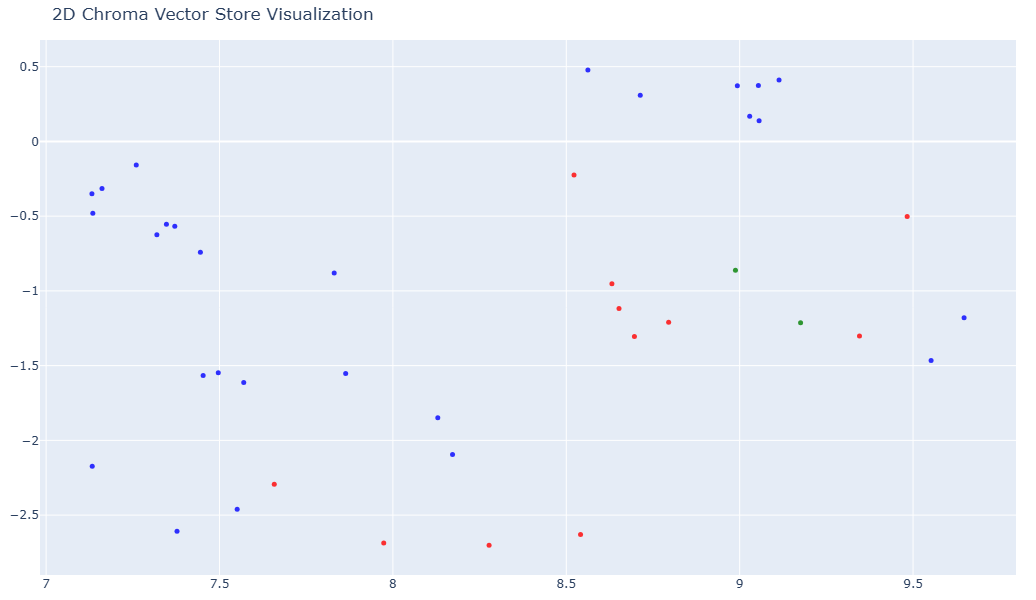

In [17]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

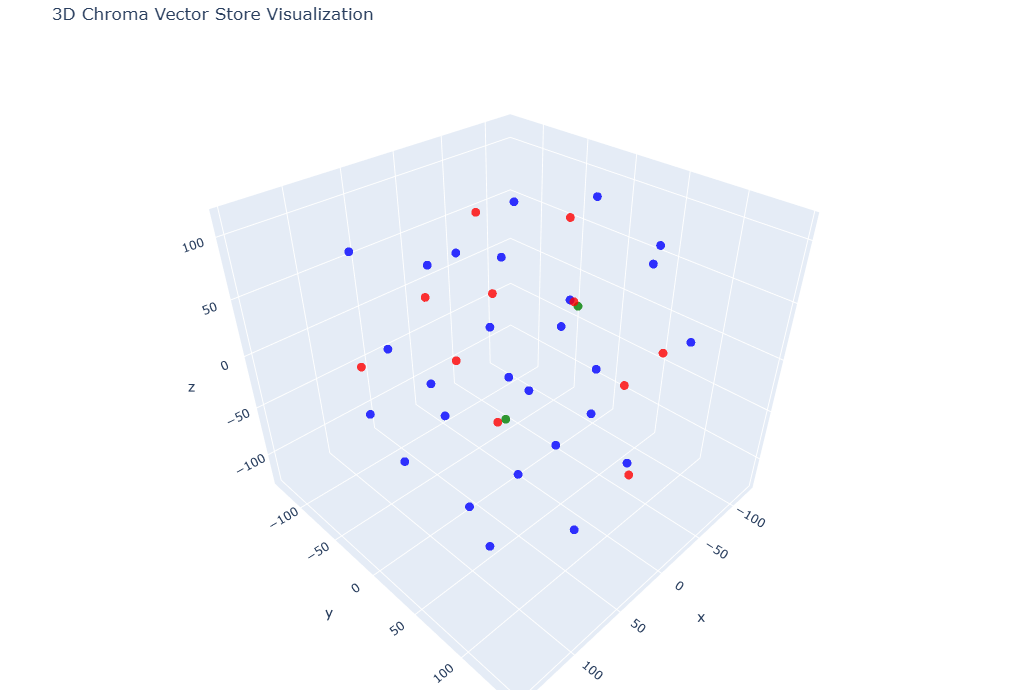

In [18]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Implement the assistant using LangChain

**Important**\
You will get a LangChainDeprecationWarning when runing the next cell about the simple way we use LangChain memory.

In [21]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG, k is how many chunks to use. 
# The number k is important to get a relevent informations
retriever = vectorstore.as_retriever(search_kwargs={"k": 20})

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
# The argument callbacks=[StdOutCallbackHandler()] is used to display in the console (stdout) what is happening behind the scenes when the model is called.
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

In [22]:
# Try a simple question

ask = "Who is Hippoyte ?"
result = conversation_chain.invoke({"question": ask})
print(result["answer"])



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
# Hi there, I'm Hippolyte SODJINOU! 👋

Welcome to my GitHub profile!
## 🔧 Technologies & Tools

- **Languages:** Python, R, C, SQL, HTML, Stata, Latex
- **Frameworks & Libraries:**  R libraries, Shiny, Numpy, Pandas, Matplotlib, Streamlit, Dash, Tkinter, Scikit-learn, TensorFlow, Keras, PyTorch, XGBoost, LightGBM, CatBoost ...
- **Databases:** MySQL, PostgreSQL, NoSQL, Microsoft SQL Server
- **Platforms:** Hugging Face, Anaconda, Kaggle,
 ABACUS.AI, Eurostat, IPUMS, Dataiku,
- **Tools:**  VS Code, JupyterLab (Anaconda),
 Google Colab, R Studio, Power BI,
 StataNow 18 MP, Pack Office, Git, Cursor, Gradio.
- **Others:** RESTful APIs, Microservices,

In [25]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Gradio Interface 

We can also use streamlit instead.

In [26]:
# Wrapping that in a function
# Note that the history offered by the Gradio interface is not used because we utilize the memory provided by LangChain Expression Language (LCL);
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [27]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.
